# Twitterでフォロワーをクラスタリングしてみた。
---
分析

## 目次
- グラフの定義（テスト）
- フォロワー同士の関係を取得
- グラフの定義
- クラスタリング
- 属性分析

In [3]:
import os, sys
sys.path.append('../')

from tqdm import tqdm
import psycopg2

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## グラフの定義（テスト）

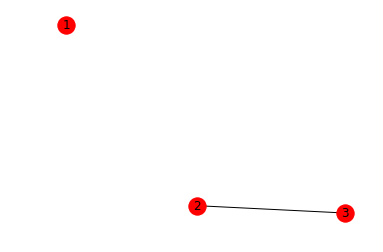

In [4]:
# グラフの定義
G = nx.Graph()
G.add_node(1) # エッジの追加
G.add_edge(2, 3)

plt.figure(figsize=(6,4))
pos = nx.spring_layout(G) # グラフにラベルつける。
nx.draw_networkx(G, pos)
plt.axis("off")
plt.show()

## フォロワー同士の関係を取得

In [5]:
# 接続情報
connection_config = {
    'host': 'localhost',
    'port': '5432',
    'database': 'my_db',
    'user': 'rui',
    'password': 'password'
}

conn = psycopg2.connect(**connection_config)

In [6]:
q_screen_name = 'rui_308'
q = "SELECT * FROM twitter.follower_user_info where slave_screen_name='%s'" % q_screen_name

follower_df = pd.read_sql(sql=q, con=conn)

In [7]:
follower_df.head()

,slave_screen_name,user_id,screen_name,friends_count,followers_count,self_discription,protected
0,rui_308,886745335,classics_jp,3074,2814,"ホメロス(H),アイスキュロス(Ac),ソフォクレス(S),エウリピデス(E),アリストパネ...",0
1,rui_308,505760483,DM_Hero,4852,3806,最近のデュエマで勝手に思ったことをカード別につぶやくbotです デュエルマスターズをやってる...,0
2,rui_308,379144705,ayataka_bot,61,52,http://t.co/OGdrONxkEE←説明書 創作bot。高天原防衛軍二番隊隊長の一...,0
3,rui_308,312027457,AAtest_bot,345,267,2chはモナー板、長編AA板の名言・迷言などを幅広く集めていくつもりのbot。こちらはテスト...,0
4,rui_308,2944058462,GMAhikaru,2500,2911,Lv17電波少女 邦ロック,0


In [8]:
follower_ids = follower_df['user_id']

In [9]:
q = "select * from twitter.friends"

friends_df = pd.read_sql(sql=q, con=conn)

In [10]:
friends_df['com_friend_ids'] = friends_df['friend_ids'].str.split(',') \
    .apply(lambda x: np.array(x).astype(int)) \
    .apply(lambda x: list(set(x) & set(follower_ids)))

In [11]:
friends_df.head()

,user_id,screen_name,friend_ids,com_friend_ids
0,1907355950,0127jdabcyasu,"1012930315755507713,946948515514609665,3145665...",[]
1,800313087039410177,ONEOKROCK_Mamo,"776049295,2939946835,907526713,819951672063447...",[]
2,777882633950801920,live_love_333,"239782959,843863742504886272,89387209332177305...","[761867125589807104, 985186612341436417, 77890..."
3,760426981594771456,s_ALXD,"3145665278,4431646093,976452610596126723,90800...","[761867125589807104, 970961373453721601, 90418..."
4,2662271406,hinatanu0713,"883850801889689600,883644726846439424,10107728...",[]


In [12]:
friends_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 4 columns):
user_id           370 non-null int64
screen_name       370 non-null object
friend_ids        370 non-null object
com_friend_ids    370 non-null object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB


In [13]:
friends_df.dtypes

user_id            int64
screen_name       object
friend_ids        object
com_friend_ids    object
dtype: object

In [16]:
print ('組み合せ総数：', friends_df['com_friend_ids'].apply(lambda x: len(x)).sum()/2)

組み合せ総数： 4425.0


## グラフの定義
1. `user_id`と`screen_name`が対応する辞書を作る
- `friends_df['com_friend_screen_name']`の定義
- グラフを定義
    - `q_screen_name`と対象フォロワーを繋げる
    - 対象フォロワー同士のエッジを追加

### user_idとscreen_nameが対応する辞書を作る
friends_df['com_friend_ids']に対応して、friends_df['com_friend_screen_name']を定義

In [17]:
df = pd.read_sql(sql="SELECT * FROM twitter.follower_user_info;", con=conn)
df.head()

,slave_screen_name,user_id,screen_name,friends_count,followers_count,self_discription,protected
0,rui_308,886745335,classics_jp,3074,2814,"ホメロス(H),アイスキュロス(Ac),ソフォクレス(S),エウリピデス(E),アリストパネ...",0
1,rui_308,505760483,DM_Hero,4852,3806,最近のデュエマで勝手に思ったことをカード別につぶやくbotです デュエルマスターズをやってる...,0
2,rui_308,379144705,ayataka_bot,61,52,http://t.co/OGdrONxkEE←説明書 創作bot。高天原防衛軍二番隊隊長の一...,0
3,rui_308,312027457,AAtest_bot,345,267,2chはモナー板、長編AA板の名言・迷言などを幅広く集めていくつもりのbot。こちらはテスト...,0
4,rui_308,2944058462,GMAhikaru,2500,2911,Lv17電波少女 邦ロック,0


In [18]:
dict_id_to_name = df[['user_id', 'screen_name']].set_index('user_id').T.to_dict()

In [19]:
# screen_nameの呼び出し方法
dict_id_to_name[761867125589807104]['screen_name']

'ra_0y'

### friends_df['com_friend_screen_name']の定義

In [20]:
friends_df['com_friend_screen_name'] = friends_df['com_friend_ids'].apply(lambda x: [dict_id_to_name[i]['screen_name'] for i in x])

In [21]:
friends_df.head()

,user_id,screen_name,friend_ids,com_friend_ids,com_friend_screen_name
0,1907355950,0127jdabcyasu,"1012930315755507713,946948515514609665,3145665...",[],[]
1,800313087039410177,ONEOKROCK_Mamo,"776049295,2939946835,907526713,819951672063447...",[],[]
2,777882633950801920,live_love_333,"239782959,843863742504886272,89387209332177305...","[761867125589807104, 985186612341436417, 77890...","[ra_0y, t109_69, am_bluen12, 06___win, rock_ke..."
3,760426981594771456,s_ALXD,"3145665278,4431646093,976452610596126723,90800...","[761867125589807104, 970961373453721601, 90418...","[ra_0y, MMM_Yuuke, lxd040124mrs, Freedom3abmss..."
4,2662271406,hinatanu0713,"883850801889689600,883644726846439424,10107728...",[],[]


### グラフを定義
1. `q_screen_name`と対象フォロワーを繋げる
- 対象フォロワー同士のエッジを追加

In [22]:
target_screen_name = friends_df['screen_name']

#### q_screen_nameと対象フォロワーを繋げる

In [23]:
# グラフの定義
G_follower = nx.Graph()

for t_name in target_screen_name:
    G_follower.add_edge(q_screen_name, t_name)